In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
#pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
line_kws={'color':'r', 'linewidth': 2}
scatter_kws=dict(s=20, marker='o', edgecolors='white', alpha=0.5)

<h1 style="color:SteelBlue; font-size:200%; line-height:1.5">Защита данных клиентов с сохранением качества работы моделей машинного обучения</h1>

Задача: разработать метод шифрования персональных данных клиентов страховой компании. Обосновать корректность работы метода.

После шифрования данных качество прогноза модели машинного обучения не должно ухудшиться. Модель машинного обучения - линейная регрессия.

<h2 style="color:DodgerBlue">Введение</h2>

В работе нужно применить модель линейной регрессии. Качество её прогноза на зашифрованных данных не должно быть хуже, чем на оригинальных. В этой ситуации логично использовать шифрование, при котором каждый зашифрованный признак является линейной комбинацией исходных признаков. Это [шифрование с помощью аналитических преобразований](https://protect.htmlweb.ru/p11.htm), а именно - с помощью линейных преобразований исходной матрицы признаков (умножения на шифрующую матрицу).

Перед тем, как заниматься шифрованием данных, нужно загрузить их и выполнить предобработку.

<h1 style="color:SteelBlue"> 1. Осмотр данных</h1>

<h2 style="color:DodgerBlue">1.1 Загрузка, общая информация о данных</h2>

In [3]:
link = 'C:/Users/Affernus/JupiterNotebooks/datasets/ML/'
clients_data = pd.read_csv(link+'insurance.csv')

In [4]:
clients_data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [5]:
clients_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
print('Полных дублей:', clients_data.duplicated().sum())

Полных дублей: 153


В наборе данных есть 153 дубликата, удалю их. Также переименую столбцы для удобства обращения к ним.

In [7]:
duplicated_indexes = clients_data[clients_data.duplicated()].index
clients_data.drop(index=duplicated_indexes, inplace=True)
clients_data.reset_index(drop=True, inplace=True)
columns_names = ['gender', 'age', 'salary', 'family_members', 'insurance_payments']
clients_data.columns = columns_names

In [8]:
clients_data.head()

,gender,age,salary,family_members,insurance_payments
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Данные представлены пятью тысячами объектов, 153 дубля (удалены). 

Всего 5 признаков, из них:

**4 предиктора:** "Пол", "Возраст", "Зарплата", "Члены семьи" <code>sex, age, salary, family_members</code>. 

**1 целевой признак:** "Страховые выплаты" <code>insurance_payments</code>

Пол - категориальный признак, закодирован OrdinalEncoder. Целевые выплаты - целочисленный количественный признак. Вектор прогноза модели, видимо, нужно округлять до целых чисел.

<h2 style="color:DodgerBlue">1.2 Оценочный анализ</h2>

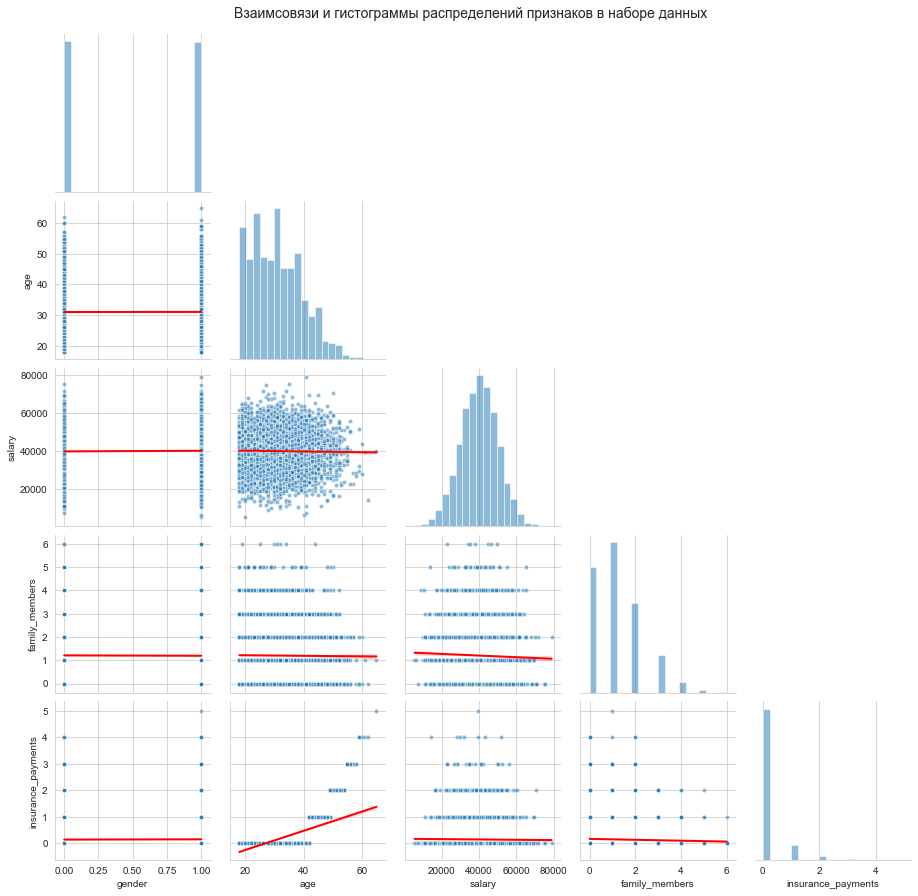

In [9]:
g = sns.pairplot(data = clients_data,
                 corner=True, 
                 kind='reg', 
                 diag_kind='auto',
                 plot_kws={'line_kws':line_kws, 'scatter_kws':scatter_kws}, 
                 diag_kws=dict(bins=20, alpha=0.5)
                )

g.fig.subplots_adjust(top=.95)
g.fig.suptitle('Взаимсовязи и гистограммы распределений признаков в наборе данных', size=14)
plt.show()

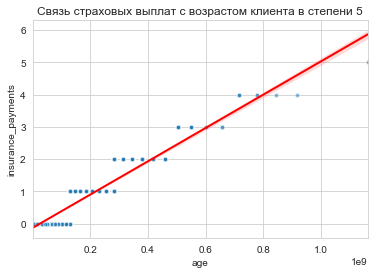

In [10]:
degree = 5
plot_kws={'line_kws':line_kws, 'scatter_kws':scatter_kws}
sns.regplot(clients_data['age']**degree, clients_data['insurance_payments'],
            **plot_kws)
plt.title(f"Связь страховых выплат с возрастом клиента в степени {degree}")
plt.show()

In [11]:
print('Уникальные значения количества страховых выплат:')
clients_data['insurance_payments'].value_counts()

Уникальные значения количества страховых выплат:


0    4284
1     423
2     114
3      18
4       7
5       1
Name: insurance_payments, dtype: int64

Явных выбросов и аномалий не наблюдается, кросс-корреляций - тоже. Прослеживается зависимость целевого признака от возраста клиента. Причём она похожа на степенную, т.е. полиномиальная регрессия должна в данной задаче показать себя лучше линейной.

Признак "Пол" можно попробовать закодировать OneHotEncoder.

Признак "Возраст" можно попробовать преобразовать таким образом, чтобы зависимость была ближе к линейной (возвести в степень).

Дисбалланс выплат довольно большой, можно попробовать upsampling и downsampling (хотя это и не задача классификации, но схожесть есть)

<h1 style="color:SteelBlue"> 2. Обучение модели на оригинальных данных</h1>

По условию задачи не нужно подбирать лучшую модель и делать feature engineering, однако я попробую вариант с возведением признака <code>age</code> в степень. Варианты кодирования, стандартизацию и проч. пробовать не буду, т.к. нет такой задачи. Сначала обучу модель на оригинальных признаках, затем попробую преобразованный признак <code>'transformed_age'</code>

Также нет задачи заниматься upsampling и downsampling, хотя дисбалланс по количеству выплат довольно значительный, можно было бы попробовать (выплаты - признак, конечно, количественный, но уникальных значений всего 6, и наиболее важны, как раз, большие количества выплат)

In [12]:
X = clients_data.drop(columns=['insurance_payments'])
y = clients_data['insurance_payments']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_predicted = linreg.predict(X_test)
y_predicted = y_predicted.round(0)
print('Метрика R2, X_test (оригинальные данные, возраст не преобразован)', r2_score(y_test, y_predicted))

Метрика R2, X_test (оригинальные данные, возраст не преобразован) 0.5941402134406082


In [13]:
print('Предсказанные объекты, у которых количество страховых выплат >=3', np.where(y_predicted >= 3))
print('Объекты, у которых страховые выплаты действительно >=3', np.where(y_test >= 3))

Предсказанные объекты, у которых количество страховых выплат >=3 (array([], dtype=int64),)
Объекты, у которых страховые выплаты действительно >=3 (array([190, 274, 601, 948], dtype=int64),)


In [14]:
clients_data.loc[:, 'transformed_age'] = clients_data['age']**5.2

In [15]:
X = clients_data.drop(columns=['insurance_payments', 'age'])
y = clients_data['insurance_payments']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
linreg.fit(X_train, y_train)
y_predicted = linreg.predict(X_test)
y_predicted = y_predicted.round(0)
print('Метрика R2, X_test (оригинальные данные, возраст возведён в степень):', r2_score(y_test, y_predicted))

Метрика R2, X_test (оригинальные данные, возраст возведён в степень): 0.9364315996955169


In [16]:
print('Предсказанные объекты, у которых количество страховых выплат >=3', np.where(y_predicted >= 3))
print('Объекты, у которых страховые выплаты действительно >=3', np.where(y_test >= 3))

Предсказанные объекты, у которых количество страховых выплат >=3 (array([190, 274, 601, 948], dtype=int64),)
Объекты, у которых страховые выплаты действительно >=3 (array([190, 274, 601, 948], dtype=int64),)


После возведения признака "возраст" в степень 5.2 наблюдается значительное улучшение метрики r2. И точно предсказаны все объекты тестовой выборки, у которых число страховых выплат больше либо равно 3. Далее буду использовать <code>'transformed_age'</code>

In [17]:
columns_names = ['gender', 'salary', 'family_members', 'transformed_age']

<h1 style="color:SteelBlue"> 3. Шифрование вектора признаков</h1>

Достаточно надежное закрытие информации может обеспечить использование при шифровании некоторых аналитических преобразований. Например, можно использовать методы алгебры матриц. [© Защита информации в компьютерных системах](https://protect.htmlweb.ru/p11.htm)

Шифрование текстов на основе матричного преобразования применяется, например, в шифре Хилла, где кодирующая матрица является словом, буквы которого закодированы числами и размещены в столбцах и строках кодирующей матрицы [см. Шифр Хилла](https://ru.wikipedia.org/wiki/%D0%A8%D0%B8%D1%84%D1%80_%D0%A5%D0%B8%D0%BB%D0%BB%D0%B0)

<h2 style="color:DodgerBlue">3.1 Алгоритм преобразования данных </h2>

Для преобразования данных предлагаю использовать алгоритм на основе линейной алгебры. Каждый признак каждого объекта должен быть представлен как линейная комбинация оригинальных признаков (соответственно, число признаков не должно меняться, чтобы не было потери информации). Это эквивалентно применению матричного преобразования к транспонированной матрице признаков:


$$ X\_encrypted = (encryption\_matrix \cdot X^T)^T $$

Или, если записать иначе:

$$ X\_encrypted = X \cdot encryption\_matrix^T $$

Т.е.:

$$ X\_encrypted = X \cdot encryption\_key $$


- X - матрица значений предикторов
- X_encrypted - матрица зашифрованных значений предикторов
- encryption_key - кодирующая матрица m x m, m - число предикторов


Для расшифровки необходимо, чтобы существовала обратная матрица к <code>encryption_key</code>, т.е. определитель кодирующей матрицы не должен быть равен нулю <code>det(encryption_key) != 0</code>. Также определитель не должен быть слишком большим или маленьким, чтобы преобразование не растягивало и не сжимало пространство за пределы длин целых чисел (иначе, даже при наличии обратной матрицы, данные можно будет восстановить только с большой погрешностью).

Качество линейной регрессии не поменяется, т.к. каждый новый признак является линейной комбинацией оригинальных признаков. Покажем это строго в следующем подразделе.

<h2 style="color:DodgerBlue">3.2 Коэффициенты линейной регрессии до и после шифрования</h2>

Если для решения задачи регрессии (нахождения регрессионных коэффициентов) используется метод наименьших квадратов, то функционал квадрата ошибки в матричной записи выглядит как:

$$ Q(\alpha, X^l) = ||F\cdot\alpha - y||^2 $$

Где:
- F - матрица предикторов
- $ alpha $ - вектор коэффициентов линейной регрессии
- y - вектор целевых признаков

Если мы кодируем матрицу предикторов: 

$$ F\_encrypted = F \cdot encryption\_key $$

То прогноз линейной регрессии не ухудшится, если найдётся такой вектор коэффициентов <code>alhpa_enc</code>, что:

$$ F\cdot\alpha - y = F\_encrypted\cdot\alpha\_enc - y  = F \cdot encryption\_key\cdot\alpha\_enc - y $$

Выполним преобразования:

$$ F\cdot\alpha = F \cdot encryption\_key\cdot\alpha\_enc $$

$$ F^{-1} \cdot F \cdot \alpha = F^{-1} \cdot F \cdot encryption\_key\cdot\alpha\_enc $$

$$ alpha = encryption\_key\cdot\alpha\_enc $$

$$ alpha\_enc = encryption\_key^{-1}\cdot\alpha $$

Т.е. если у кодирующей матрицы есть обратная (детерминант кодирующей матрицы не равен нулю), то существует такой вектор коэффициентов alpha_enc, при котором значение функционала квадрата ошибки не ухудшится относительно оригинальных признаков.

<h2 style="color:DodgerBlue">3.3 Шифрование вектора признаков (данных пользователей)</h2>

Кодирующая матрица должна быть квадратной матрицей размера m x m, где m - количество предикторов. Можно создать такую матрицу из кодового слова, аналогично шифру Хилла. Однако, в данной задаче этого не требуется и я создам кодирующую матрицу при помощи <code>np.random.randint</code> (можно <code>np.random.randn</code>, но целочисленная матрица удобнее при передаче коллегам). Задам большие значения элементов в диапазоне -1000 до 1000, т.к. в оригинальных данных признаки имеют разные порядки (например пол (1, 0) и зарплата (10^3 - 10^4)). Если в кодирующей матрице будут небольшие значения, то признаки будут плохо закодированы (можно было бы, конечно, сначала их стандартизовать и кодировать бинарной матрицей).

In [18]:
print('Размер матрицы предикторов:', X.shape)

Размер матрицы предикторов: (4847, 4)


In [19]:
print('Матрица предикторов:')
X.head()

Матрица предикторов:


,gender,salary,family_members,transformed_age
0,1,49600.0,1,2.434872e+08
1,0,38000.0,1,4.429357e+08
2,0,21000.0,0,4.022255e+07
3,0,41700.0,2,7.508278e+06
4,1,26100.0,0,3.351365e+07


In [20]:
import sys
sys.float_info

sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)

In [21]:
np.random.seed(271828)
encryption_key = np.random.randint(-100, 100, size=(X.shape[1], X.shape[1]), dtype='l') 

In [22]:
print('Кодирующая матрица:\n')
print(encryption_key)

Кодирующая матрица:

[[ 30 -44  97  92]
 [ 94   6  19  -4]
 [-74   1 -92 -82]
 [ 80  83  -2  13]]


In [23]:
print('Детерминант кодирующей матрицы:')
enc_det = np.linalg.det(encryption_key)
print(enc_det)
if enc_det != 0:
    print('Детерминант кодирующей матрицы не равен нулю, обратная матрица существует')
else:
    print('Детерминант кодирующей матрицы равен нулю. Такая матрица не подойдёт!')

Детерминант кодирующей матрицы:
-6340624.000000006
Детерминант кодирующей матрицы не равен нулю, обратная матрица существует


In [24]:
decryption_key = np.linalg.inv(encryption_key)
print('Матрица, обратная кодирующей:\n')
print(decryption_key)

Матрица, обратная кодирующей:

[[ 0.02653635  0.01588566  0.03098654  0.01254577]
 [-0.04167319 -0.01686427 -0.04724141 -0.00825534]
 [-0.09971984 -0.01916878 -0.11887978 -0.05004555]
 [ 0.08742515  0.00696493  0.09264262  0.0447262 ]]


In [27]:
X_encrypted = np.dot(X, encryption_key)
print('Закодированная матрица предикторов:')
display(pd.DataFrame(X_encrypted, columns = columns_names).head())

Закодированная матрица предикторов:


,gender,salary,family_members,transformed_age
0,1.948363e+10,2.020973e+10,-4.860319e+08,3.165135e+09
1,3.543843e+10,3.676389e+10,-8.851496e+08,5.758013e+09
2,3.219778e+09,3.338598e+09,-8.004610e+07,5.228091e+08
3,6.045819e+08,6.234373e+08,-1.422444e+07,9.744065e+07
4,2.683546e+09,2.781790e+09,-6.653131e+07,4.355732e+08


In [30]:
X_decrypted = np.dot(X_encrypted, decryption_key)
print('Раскодированная матрица предикторов:')
display(pd.DataFrame(X_decrypted, columns = columns_names).round(0).head())

Раскодированная матрица предикторов:


,gender,salary,family_members,transformed_age
0,1.0,49600.0,1.0,243487155.0
1,-0.0,38000.0,1.0,442935740.0
2,0.0,21000.0,0.0,40222549.0
3,0.0,41700.0,2.0,7508278.0
4,1.0,26100.0,0.0,33513653.0


In [31]:
print('Суммарные абсолютные различия в оригинальной и раскодированной матрице:')
(abs(X - X_decrypted)).sum().round(3)

Суммарные абсолютные различия в оригинальной и раскодированной матрице:


gender             0.0
salary             0.0
family_members     0.0
transformed_age    0.0
dtype: float64

Кодирование и раскодирование работают адекватно. С точностью до третьего знака абсолютная сумма отклонений значений признаков раскодированной матрицы от оригинальной равна 0.

<h1 style="color:SteelBlue"> 4. Обучение модели на зашифрованных данных</h1>

In [32]:
X = clients_data.drop(columns=['insurance_payments', 'age'])
y = clients_data['insurance_payments']
X_train, X_test, y_train, y_test = train_test_split(X_encrypted, y, test_size=0.2, random_state=12345)
linreg.fit(X_train, y_train)
y_predicted = linreg.predict(X_test)
y_predicted = y_predicted.round(0)
print('Метрика R2 (зашифрованные данные, возраст возведён в степень):', r2_score(y_test, y_predicted))

Метрика R2 (зашифрованные данные, возраст возведён в степень): 0.9364315996955169


Как и предполагалось, матричное шифрование признаков не влияет на качество прогноза линейной регрессии.

<h1 style="color:SteelBlue"> Общий вывод</h1>

В работе требовалось разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. При этом качество прогноза линейной регрессии на зашифрованных данных не должно было ухудшиться. В качестве метрики использовалась r2.

Данные представлены пятью тысячами объектов, 153 дубля (удалены). 

Всего 5 признаков, из них:

**4 предиктора:** "Пол", "Возраст", "Зарплата", "Члены семьи" <code>sex, age, salary, family_members</code>. 

**1 целевой признак:** "Страховые выплаты" <code>insurance_payments</code>

В процессе EDA установлено, что есть нелинейная взаимосвязь "Возраст" - "Страховые выплаты". Аномалий, выбросов и кросс-корреляционных связей между предикторами не найдено. Проведен feature engineering: вместо признака <code>"Возраст"</code> создан признак <code>'transformed_age'</code>. Совместно с округлением предсказанных значений страховых выплат до целых чисел это позволило получить метрику <code>r2 = 0.936</code> на тестовой выборке.

Для преобразования данных предложен алгоритм на основе методов линейной алгебры. Каждый признак каждого объекта представлен как линейная комбинация оригинальных признаков, что эквивалентно применению матричного преобразования:

$$ X\_encrypted = X \cdot encryption\_key $$

- X - матрица значений предикторов
- X_encrypted - матрица зашифрованных значений предикторов
- encryption_key - кодирующая матрица m x m, m - число предикторов

Показано, что качество прогноза линейной регрессии не поменяется, если кодирующая матрица обратима. При этом:

$$ alpha\_enc = encryption\_key^{-1}\cdot\alpha $$

- alpha_enc - коэффициенты линейной регрессии после шифрования предикторов
- alpha - коэффициенты линейной регрессии для оригинальных значений предикторов
- encryption_key - кодирующая матрица m x m, m - число предикторов

Кодирующая матрица построена методом np.random.randint. Проверена адекватность работы шифрования: расшифрованная матрица совпадает с оригинальной (с точностью до третьего знака абсолютная сумма отклонений значений признаков расшифрованной матрицы от оригинальной равна 0) 

Обучены модели линейной регрессии для оригинальной матрицы предикторов и для зашифрованной матрицы. Значение метрики r2 полностью идентичны (r2 = 0.9364315996955169).